
# CatBoost Diabetes Classifier

Train a high performing CatBoost model for the BRFSS diabetes classification dataset with stratified 60/20/20 splits, cross-validated hyperparameter search, and class weighting to handle the 85% positive class imbalance.



## Workflow
- Load the BRFSS diabetes dataset and binarize the `Diabetes_012` target so classes 1 (prediabetes) and 2 (diabetes) map to a single positive class.
- Stratify into 60% train / 20% validation / 20% test splits to preserve the high positive-class prevalence and keep the test set completely unseen.
- Compute inverse-frequency class weights so the minority negative class is emphasized across training and cross-validation folds.
- Run a small, high-quality hyperparameter search with stratified 3-fold cross-validation and early stopping enabled in every fold.
- Refit the best model on the train split (still monitored by the validation split for early stopping) and report validation/test metrics plus feature importances.


In [1]:

from pathlib import Path
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
RANDOM_STATE = 42


In [2]:

data_path = Path("diabetes_012_health_indicators_BRFSS2015.csv") / "diabetes_012_health_indicators_BRFSS2015.csv"
assert data_path.exists(), f"Cannot find dataset at {data_path}!"

df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (253680, 22)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:

df = df.copy()
df["diabetes_binary"] = (df["Diabetes_012"] >= 1).astype(int)
print("Class distribution (0 = no diabetes, 1 = pre/diabetes):")
print(df["diabetes_binary"].value_counts(normalize=True).rename(lambda x: f"class_{x}"))

feature_cols = [col for col in df.columns if col not in {"Diabetes_012", "diabetes_binary"}]
X = df[feature_cols]
y = df["diabetes_binary"]


Class distribution (0 = no diabetes, 1 = pre/diabetes):
diabetes_binary
class_0    0.842412
class_1    0.157588
Name: proportion, dtype: float64


In [4]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.40,
    stratify=y,
    random_state=RANDOM_STATE,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=RANDOM_STATE,
)

print(f"Train size: {len(X_train)} ({len(X_train)/len(X):.1%})")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(X):.1%})")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X):.1%})")


Train size: 152208 (60.0%)
Validation size: 50736 (20.0%)
Test size: 50736 (20.0%)


In [5]:

def compute_class_weights(y_series):
    counts = y_series.value_counts().sort_index()
    total = len(y_series)
    weights = {cls: total / (len(counts) * count) for cls, count in counts.items()}
    return [weights.get(0, 1.0), weights.get(1, 1.0)]

class_weights = compute_class_weights(y_train)
print(f"Training class weights [no_diabetes, diabetes]: {class_weights}")


Training class weights [no_diabetes, diabetes]: [0.5935330910452185, 3.1728508296506295]


In [6]:

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

param_grid = [
    {"depth": 4, "learning_rate": 0.03, "l2_leaf_reg": 3, "bagging_temperature": 0.25, "subsample": 0.8, "grow_policy": "SymmetricTree"},
    {"depth": 5, "learning_rate": 0.05, "l2_leaf_reg": 5, "bagging_temperature": 0.75, "subsample": 0.9, "grow_policy": "SymmetricTree"},
    {"depth": 6, "learning_rate": 0.04, "l2_leaf_reg": 6, "bagging_temperature": 1.5, "subsample": 0.85, "grow_policy": "SymmetricTree"},
    {"depth": 6, "learning_rate": 0.07, "l2_leaf_reg": 4, "bagging_temperature": 1.0, "subsample": 0.8, "grow_policy": "Depthwise"},
    {"depth": 7, "learning_rate": 0.05, "l2_leaf_reg": 8, "bagging_temperature": 0.5, "subsample": 0.85, "grow_policy": "Depthwise"},
]

cv_results = []
for params in param_grid:
    fold_scores = []
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        cw = compute_class_weights(y_tr)

        model = CatBoostClassifier(
            iterations=2000,
            loss_function="Logloss",
            eval_metric="AUC",
            random_seed=RANDOM_STATE,
            verbose=False,
            early_stopping_rounds=100,
            use_best_model=True,
            class_weights=cw,
            **params,
        )
        model.fit(X_tr, y_tr, eval_set=(X_va, y_va))
        probs = model.predict_proba(X_va)[:, 1]
        fold_scores.append(roc_auc_score(y_va, probs))

    mean_score = float(np.mean(fold_scores))
    std_score = float(np.std(fold_scores))
    result_entry = {"params": params, "mean_val_auc": mean_score, "std_val_auc": std_score}
    cv_results.append(result_entry)
    print(f"Params: {params} AUC: {mean_score:.4f} ± {std_score:.4f}")

cv_results_df = (
    pd.DataFrame(cv_results)
    .sort_values(by="mean_val_auc", ascending=False)
    .reset_index(drop=True)
)
cv_results_df


Params: {'depth': 4, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'bagging_temperature': 0.25, 'subsample': 0.8, 'grow_policy': 'SymmetricTree'} AUC: 0.8260 ± 0.0007
Params: {'depth': 5, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'bagging_temperature': 0.75, 'subsample': 0.9, 'grow_policy': 'SymmetricTree'} AUC: 0.8260 ± 0.0008
Params: {'depth': 6, 'learning_rate': 0.04, 'l2_leaf_reg': 6, 'bagging_temperature': 1.5, 'subsample': 0.85, 'grow_policy': 'SymmetricTree'} AUC: 0.8261 ± 0.0007
Params: {'depth': 6, 'learning_rate': 0.07, 'l2_leaf_reg': 4, 'bagging_temperature': 1.0, 'subsample': 0.8, 'grow_policy': 'Depthwise'} AUC: 0.8253 ± 0.0008
Params: {'depth': 7, 'learning_rate': 0.05, 'l2_leaf_reg': 8, 'bagging_temperature': 0.5, 'subsample': 0.85, 'grow_policy': 'Depthwise'} AUC: 0.8253 ± 0.0007


,params,mean_val_auc,std_val_auc
0,"{'depth': 6, 'learning_rate': 0.04, 'l2_leaf_r...",0.826092,0.000680
1,"{'depth': 5, 'learning_rate': 0.05, 'l2_leaf_r...",0.826046,0.000752
2,"{'depth': 4, 'learning_rate': 0.03, 'l2_leaf_r...",0.826039,0.000659
3,"{'depth': 6, 'learning_rate': 0.07, 'l2_leaf_r...",0.825308,0.000759
4,"{'depth': 7, 'learning_rate': 0.05, 'l2_leaf_r...",0.825288,0.000698


In [7]:

best_params = cv_results_df.iloc[0]["params"]
print("Best hyperparameters:")
print(best_params)


Best hyperparameters:
{'depth': 6, 'learning_rate': 0.04, 'l2_leaf_reg': 6, 'bagging_temperature': 1.5, 'subsample': 0.85, 'grow_policy': 'SymmetricTree'}


In [8]:

final_model = CatBoostClassifier(
    iterations=3000,
    loss_function="Logloss",
    eval_metric="AUC",
    random_state=RANDOM_STATE,
    verbose=250,
    early_stopping_rounds=150,
    use_best_model=True,
    class_weights=class_weights,
    **best_params,
)

final_model.fit(X_train, y_train, eval_set=(X_val, y_val))


0:	test: 0.7996455	best: 0.7996455 (0)	total: 14.4ms	remaining: 43.2s
250:	test: 0.8231574	best: 0.8231574 (250)	total: 3.51s	remaining: 38.4s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8232442131
bestIteration = 293

Shrink model to first 294 iterations.


In [9]:

def evaluate_split(model, X_split, y_split, name: str):
    probs = model.predict_proba(X_split)[:, 1]
    preds = (probs >= 0.5).astype(int)
    print(f"=== {name} metrics ===")
    print(f"ROC AUC: {roc_auc_score(y_split, probs):.4f}")
    print("Classification report:")
    print(classification_report(y_split, preds, target_names=["no_diabetes", "diabetes"]))
    print("Confusion matrix:")
    print(confusion_matrix(y_split, preds))
    return probs, preds

val_probs, val_preds = evaluate_split(final_model, X_val, y_val, name="Validation")


=== Validation metrics ===
ROC AUC: 0.8232
Classification report:
              precision    recall  f1-score   support

 no_diabetes       0.95      0.70      0.81     42740
    diabetes       0.33      0.79      0.47      7996

    accuracy                           0.72     50736
   macro avg       0.64      0.74      0.64     50736
weighted avg       0.85      0.72      0.75     50736

Confusion matrix:
[[30037 12703]
 [ 1704  6292]]


In [10]:

test_probs, test_preds = evaluate_split(final_model, X_test, y_test, name="Test")


=== Test metrics ===
ROC AUC: 0.8263
Classification report:
              precision    recall  f1-score   support

 no_diabetes       0.95      0.71      0.81     42741
    diabetes       0.34      0.79      0.47      7995

    accuracy                           0.72     50736
   macro avg       0.64      0.75      0.64     50736
weighted avg       0.85      0.72      0.76     50736

Confusion matrix:
[[30308 12433]
 [ 1669  6326]]


C:\Users\tyler\AppData\Local\Temp\ipykernel_10216\1347260666.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")


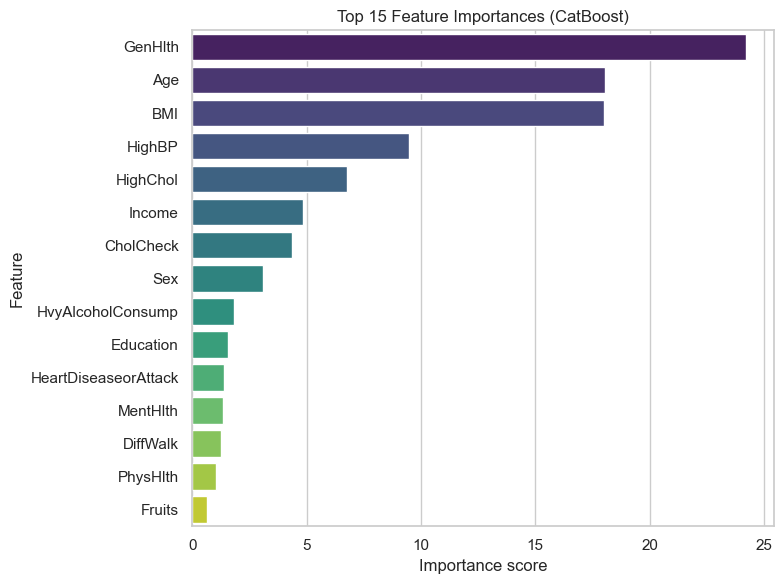

In [12]:

feature_importances = (
    pd.Series(final_model.get_feature_importance(), index=feature_cols)
    .sort_values(ascending=False)
    .head(15)
)
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.title("Top 15 Feature Importances (CatBoost)")
plt.xlabel("Importance score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:

plt.figure(figsize=(6, 6))
fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.plot(fpr, tpr, label=f"Test ROC AUC = {roc_auc_score(y_test, test_probs):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CatBoost ROC Curve (Test Set)")
plt.legend()
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()



## Logistic Regression Baseline
To complement CatBoost with a linear model, we train a logistic regression classifier on standardized features with L2 regularization. The same 60/20/20 stratified splits are reused, and we again apply inverse-frequency class weights plus 5-fold stratified cross-validation (ROC AUC scoring) to tune the regularization strength.


In [13]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_reg_class_weight = {0: class_weights[0], 1: class_weights[1]}
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    (
        "logistic",
        LogisticRegression(
            penalty="l2",
            class_weight=log_reg_class_weight,
            max_iter=2000,
            solver="lbfgs",
        ),
    ),
])

log_reg_param_grid = {
    "logistic__C": [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0],
}

log_reg_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

log_reg_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=log_reg_param_grid,
    cv=log_reg_cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
)

log_reg_search.fit(X_train, y_train)
print(f"Best CV ROC AUC: {log_reg_search.best_score_:.4f}")
print("Best Params:", log_reg_search.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best CV ROC AUC: 0.8188
Best Params: {'logistic__C': 0.01}


In [14]:

log_reg_best = log_reg_search.best_estimator_
_ = evaluate_split(log_reg_best, X_val, y_val, name="LogReg Validation")


=== LogReg Validation metrics ===
ROC AUC: 0.8146
Classification report:
              precision    recall  f1-score   support

 no_diabetes       0.94      0.72      0.82     42740
    diabetes       0.34      0.76      0.47      7996

    accuracy                           0.73     50736
   macro avg       0.64      0.74      0.64     50736
weighted avg       0.85      0.73      0.76     50736

Confusion matrix:
[[30799 11941]
 [ 1938  6058]]


In [15]:

_ = evaluate_split(log_reg_best, X_test, y_test, name="LogReg Test")


=== LogReg Test metrics ===
ROC AUC: 0.8176
Classification report:
              precision    recall  f1-score   support

 no_diabetes       0.94      0.72      0.82     42741
    diabetes       0.34      0.77      0.47      7995

    accuracy                           0.73     50736
   macro avg       0.64      0.74      0.65     50736
weighted avg       0.85      0.73      0.76     50736

Confusion matrix:
[[30916 11825]
 [ 1876  6119]]


C:\Users\tyler\AppData\Local\Temp\ipykernel_10216\233295879.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df.values, y=coef_df.index, palette="magma")


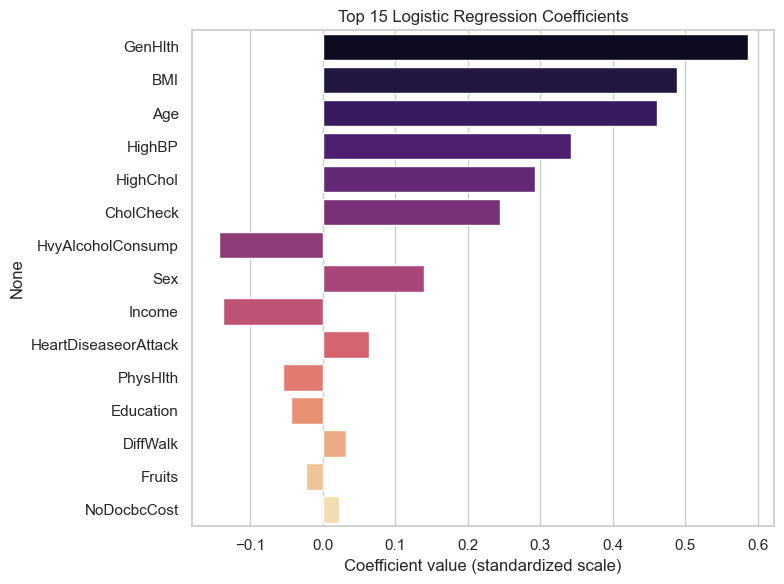

In [16]:

coefficients = log_reg_best.named_steps["logistic"].coef_[0]
coef_df = pd.Series(coefficients, index=feature_cols).sort_values(key=np.abs, ascending=False).head(15)
plt.figure(figsize=(8, 6))
sns.barplot(x=coef_df.values, y=coef_df.index, palette="magma")
plt.title("Top 15 Logistic Regression Coefficients")
plt.xlabel("Coefficient value (standardized scale)")
plt.tight_layout()
plt.show()
